In [42]:
from sklearn import datasets as ds
import polars as pl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions

In [71]:
import torchmetrics as thm

import torch as th
print(th.__version__)


1.12.1+cu102


#### Make Classification Data for PyTorch

In [3]:
# Create a dataset with 1000 samples and 2 features
x, y = ds.make_circles(n_samples=1000, noise=0.1, random_state=42)

# Convert to polars DataFrame
df = pl.DataFrame({"x1": x[:, 0], "x2": x[:, 1], "y": y})

print(df.head())

# Check the number of different classes
print(df["y"].value_counts())

shape: (5, 3)
┌───────────┬───────────┬─────┐
│ x1        ┆ x2        ┆ y   │
│ ---       ┆ ---       ┆ --- │
│ f64       ┆ f64       ┆ i64 │
╞═══════════╪═══════════╪═════╡
│ 0.712108  ┆ 0.284698  ┆ 1   │
│ -0.678716 ┆ 0.207274  ┆ 1   │
│ -0.866026 ┆ 0.343651  ┆ 1   │
│ -0.517648 ┆ 0.620599  ┆ 1   │
│ 0.454089  ┆ -0.890466 ┆ 0   │
└───────────┴───────────┴─────┘
shape: (2, 2)
┌─────┬────────┐
│ y   ┆ counts │
│ --- ┆ ---    │
│ i64 ┆ u32    │
╞═════╪════════╡
│ 0   ┆ 500    │
│ 1   ┆ 500    │
└─────┴────────┘


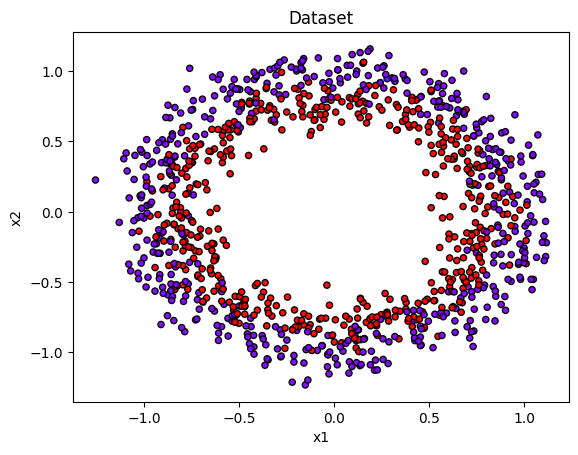

In [4]:
# Plot the dataset
plt.scatter(df["x1"], df["x2"], c=df["y"], cmap="rainbow", alpha=0.95, edgecolors="k", s=20, linewidth=1)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset")
plt.show()

##### Input and Output Shapes

In [5]:
# Check the shape of the matrix features and the target vector
print(f"Shape of the features matrix: {x.shape}")
print(f"Shape of the target vector: {y.shape}")

Shape of the features matrix: (1000, 2)
Shape of the target vector: (1000,)


##### Turn Data into Tensors

In [6]:
# Create a PyTorch tensor from the features matrix
x = th.tensor(x, dtype=th.float32)

# Create a PyTorch tensor from the target vector
y = th.tensor(y, dtype=th.float32).reshape(-1, 1)

# Check the shape of the tensor features and the target vector
print(f"Shape of the features tensor: {x.shape}")
print(f"Shape of the target tensor: {y.shape}")

Shape of the features tensor: torch.Size([1000, 2])
Shape of the target tensor: torch.Size([1000, 1])


In [7]:
# Split the dataset into training and test sets
train_size = int(0.8 * len(x))
test_size = len(x) - train_size
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check the shape of the training and test sets
print(f"Shape of the training features tensor: {x_train.shape}")
print(f"Shape of the training target tensor: {y_train.shape}")
print(f"Shape of the test features tensor: {x_test.shape}")
print(f"Shape of the test target tensor: {y_test.shape}")

Shape of the training features tensor: torch.Size([800, 2])
Shape of the training target tensor: torch.Size([800, 1])
Shape of the test features tensor: torch.Size([200, 2])
Shape of the test target tensor: torch.Size([200, 1])


#### Building a Model with PyTorch

In [8]:
# Set the device
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [9]:
# Construct a model class that subclasses nn.Module
class Model(th.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = th.nn.Linear(x.shape[1], 12)
        self.linear2 = th.nn.Linear(12, 1)
        self.sigmoid = th.nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x
    

In [10]:
# Create an instance of the model
model_a = Model().to(device)

# Check the model
print(model_a)
print(model_a.parameters)
print(model_a.state_dict())

Model(
  (linear1): Linear(in_features=2, out_features=12, bias=True)
  (linear2): Linear(in_features=12, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
<bound method Module.parameters of Model(
  (linear1): Linear(in_features=2, out_features=12, bias=True)
  (linear2): Linear(in_features=12, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)>
OrderedDict([('linear1.weight', tensor([[ 0.0540, -0.5834],
        [-0.3630,  0.3627],
        [ 0.0125, -0.5848],
        [ 0.7061, -0.5085],
        [ 0.3245, -0.0236],
        [-0.1593, -0.5954],
        [ 0.0562, -0.4548],
        [ 0.1476, -0.5106],
        [ 0.0850,  0.3521],
        [ 0.6216, -0.4611],
        [-0.3411, -0.0848],
        [-0.0914,  0.2739]])), ('linear1.bias', tensor([-2.3168e-01,  2.0227e-01,  2.8689e-01,  5.3064e-01, -5.2353e-01,
         1.8242e-01,  1.7070e-01, -2.2181e-01,  4.3310e-04, -4.9045e-01,
         5.0301e-01, -4.9480e-01])), ('linear2.weight', tensor([[ 0.2768,  0.0486,  0.0409,  0.2286,  0.0713,  0.0

In [11]:
# Create a model with nn.seqential
model_b = th.nn.Sequential(th.nn.Linear(x.shape[1], 12),  th.nn.Linear(12, 1), th.nn.Sigmoid()).to(device)
model_b = model_b.to(device)

# Check the model
print(model_b)
print(model_b.parameters)
print(model_b.state_dict())

Sequential(
  (0): Linear(in_features=2, out_features=12, bias=True)
  (1): Linear(in_features=12, out_features=1, bias=True)
  (2): Sigmoid()
)
<bound method Module.parameters of Sequential(
  (0): Linear(in_features=2, out_features=12, bias=True)
  (1): Linear(in_features=12, out_features=1, bias=True)
  (2): Sigmoid()
)>
OrderedDict([('0.weight', tensor([[-0.2882,  0.1657],
        [-0.3631, -0.6959],
        [ 0.2228,  0.1429],
        [ 0.6494,  0.1957],
        [-0.5569,  0.5923],
        [-0.0676,  0.1220],
        [ 0.1778, -0.2465],
        [-0.4750, -0.6111],
        [ 0.6651, -0.6213],
        [ 0.5976,  0.1909],
        [ 0.6386, -0.3367],
        [-0.5680, -0.3652]])), ('0.bias', tensor([ 0.6247,  0.2967,  0.1036, -0.0192,  0.1218,  0.2020, -0.6318, -0.2474,
        -0.1600,  0.5833,  0.3288, -0.3265])), ('1.weight', tensor([[-0.0990,  0.0805,  0.0988,  0.1858,  0.0569,  0.0372,  0.0254,  0.0553,
          0.1507,  0.1441,  0.0722,  0.0558]])), ('1.bias', tensor([0.2020]))

In [12]:
# Make predictions with the model
y_test_pred = model_a(x_test)

# Check the shape of the predictions and target vectors
print(f"Shape of the predictions: {y_test_pred.shape}")
print(f"Shape of the target: {y_test.shape}")

Shape of the predictions: torch.Size([200, 1])
Shape of the target: torch.Size([200, 1])


#### Setup Loss Function and Optimizer

In [13]:
# Create an instance of the model
model_c = Model().to(device)

# Create a loss function
loss_fn = th.nn.BCELoss()

# Create an optimizer
optimizer = th.optim.SGD(model_c.parameters(), lr=0.01, momentum=0.9)

In [14]:
# Calculate accuracy metric function
def accuracy(y_pred, y_true):
    """
    Calculate the accuracy of the predictions.

    Args:
        y_pred (_type_): _description_
        y_true (_type_): _description_

    Returns:
        _type_: _description_
    """
    y_pred = th.round(y_pred)

    acc = (y_pred == y_true).sum().item() / len(y_true)
    # or
    acc = th.sum(y_pred == y_true).item() / len(y_true)
    # or
    acc = th.mean((y_pred == y_true).float()).item()
    # or
    acc = th.eq(y_pred, y_true).float().mean().item()
    return round(acc, 4)

In [15]:
accuracy(y_test_pred, y_test)

0.39

#### Train the Model

In [16]:
# Set the manual seed for reproducibility
th.manual_seed(42)

# Create an instance of the model
model_c = Model().to(device)

# Create a loss function
loss_fn = th.nn.BCELoss()

# Create an optimizer
optimizer = th.optim.SGD(model_c.parameters(), lr=0.01, momentum=0.9)


# train the model
def train_model(model, x_train, y_train, x_test, y_test, loss_fn, optimizer, epochs):
    """
    Train the model.

    Args:
        model (_type_): _description_
        x_train (_type_): _description_
        y_train (_type_): _description_
        x_test (_type_): _description_
        y_test (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
        epochs (_type_): _description_

    Returns:
        _type_: _description_
    """
    train_losses = []
    train_matrics = []
    test_losses = []
    test_matrics = []

    for epoch in range(epochs):
        
        # Train
        model.train()

        # Make predictions
        y_train_pred = model(x_train)

        # Calculate loss
        train_loss = loss_fn(y_train_pred, y_train)

        # Calculate accuracy
        train_acc = accuracy(y_train_pred, y_train)

        # Reset gradients
        optimizer.zero_grad()

        # Calculate gradients
        train_loss.backward()

        # Update parameters
        optimizer.step()

        # Test
        model.eval()

        with th.inference_mode():
            # Make predictions
            y_test_pred = model(x_test)

            # Calculate loss
            test_loss = loss_fn(y_test_pred, y_test)

            # Calculate accuracy
            test_acc = accuracy(y_test_pred, y_test)

        train_losses.append(train_loss.item())
        train_matrics.append(train_acc)
        test_losses.append(test_loss.item())
        test_matrics.append(test_acc)

        if epoch % 100 == 0:
            # Print the progress
            print(f"Epoch {epoch}: train loss: {train_losses[epoch]}, train acc: {train_matrics[epoch]}")
            
            print(f"Epoch {epoch}: test loss: {test_losses[epoch]}, test acc: {test_matrics[epoch]}")

    return train_losses, train_matrics, test_losses, test_matrics


In [17]:
train_losses, train_matrics, test_losses, test_matrics = train_model(model_c, x_train, y_train, x_test, y_test, loss_fn, optimizer, 1000)

Epoch 0: train loss: 0.695187509059906, train acc: 0.545
Epoch 0: test loss: 0.7099666595458984, test acc: 0.43
Epoch 100: train loss: 0.6925979852676392, train acc: 0.5175
Epoch 100: test loss: 0.6996195912361145, test acc: 0.435
Epoch 200: train loss: 0.692574679851532, train acc: 0.53
Epoch 200: test loss: 0.6988627910614014, test acc: 0.43
Epoch 300: train loss: 0.6925743222236633, train acc: 0.5312
Epoch 300: test loss: 0.6987789273262024, test acc: 0.425
Epoch 400: train loss: 0.6925743222236633, train acc: 0.5312
Epoch 400: test loss: 0.6987677812576294, test acc: 0.425
Epoch 500: train loss: 0.6925743222236633, train acc: 0.5312
Epoch 500: test loss: 0.6987663507461548, test acc: 0.425
Epoch 600: train loss: 0.6925743222236633, train acc: 0.5312
Epoch 600: test loss: 0.6987661719322205, test acc: 0.425
Epoch 700: train loss: 0.6925743222236633, train acc: 0.5312
Epoch 700: test loss: 0.6987661123275757, test acc: 0.425
Epoch 800: train loss: 0.6925743222236633, train acc: 0.531

In [18]:
# Create an instance of the model
model_c = Model().to(device)

# Create a loss function
loss_fn = th.nn.BCELoss()

# Create an optimizer
optimizer = th.optim.SGD(model_c.parameters(), lr=0.01, momentum=0.9)

# Train the model with torchmetrics
def train_model(model, x_train, y_train, x_test, y_test, loss_fn, optimizer, epochs):
    """
    Train the model.

    Args:
        model (_type_): _description_
        x_train (_type_): _description_
        y_train (_type_): _description_
        x_test (_type_): _description_
        y_test (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
        epochs (_type_): _description_

    Returns:
        _type_: _description_
    """
    train_losses = []
    train_matrics = []
    test_losses = []
    test_matrics = []

    thm.Accuracy(task="binary", threshold=0.5)
    
    for epoch in range(epochs):
        
        # Train
        model.train()

        # Make predictions
        y_train_pred = model(x_train)

        # Calculate loss
        train_loss = loss_fn(y_train_pred, y_train)

        # Calculate accuracy
        train_acc = accuracy(y_train_pred, y_train)

        # Reset gradients
        optimizer.zero_grad()

        # Calculate gradients
        train_loss.backward()

        # Update parameters
        optimizer.step()

        # Test
        model.eval()

        with th.inference_mode():
            # Make predictions
            y_test_pred = model(x_test)

            # Calculate loss
            test_loss = loss_fn(y_test_pred, y_test)

            # Calculate accuracy
            test_acc = accuracy(y_test_pred, y_test)

        train_losses.append(train_loss.item())
        train_matrics.append(train_acc)
        test_losses.append(test_loss.item())
        test_matrics.append(test_acc)

        if epoch % 100 == 0:
            # Print the progress
            print(f"Epoch {epoch}: train loss: {train_losses[epoch]}, train acc: {train_matrics[epoch]}")
            
            print(f"Epoch {epoch}: test loss: {test_losses[epoch]}, test acc: {test_matrics[epoch]}")

    return train_losses, train_matrics, test_losses, test_matrics

In [19]:
train_losses, train_matrics, test_losses, test_matrics = train_model(model_c, x_train, y_train, x_test, y_test, loss_fn, optimizer, 1000)

Epoch 0: train loss: 0.6966955661773682, train acc: 0.4913
Epoch 0: test loss: 0.6961306929588318, test acc: 0.495
Epoch 100: train loss: 0.6926184296607971, train acc: 0.5238
Epoch 100: test loss: 0.6973552107810974, test acc: 0.42
Epoch 200: train loss: 0.6925747394561768, train acc: 0.5325
Epoch 200: test loss: 0.6986228823661804, test acc: 0.43
Epoch 300: train loss: 0.6925743222236633, train acc: 0.5312
Epoch 300: test loss: 0.6987521648406982, test acc: 0.425
Epoch 400: train loss: 0.6925743222236633, train acc: 0.5312
Epoch 400: test loss: 0.6987648010253906, test acc: 0.425
Epoch 500: train loss: 0.6925743222236633, train acc: 0.5312
Epoch 500: test loss: 0.6987659335136414, test acc: 0.425
Epoch 600: train loss: 0.6925743222236633, train acc: 0.5312
Epoch 600: test loss: 0.6987659931182861, test acc: 0.425
Epoch 700: train loss: 0.6925743222236633, train acc: 0.5312
Epoch 700: test loss: 0.6987659931182861, test acc: 0.425
Epoch 800: train loss: 0.6925743222236633, train acc: 

In [20]:
metric = thm.Accuracy(task="binary", threshold=0.5)
metric(y_test_pred, y_test)

tensor(0.3900)

#### Improving the Model

In [21]:
# Improve the model
class ImprovedModel(th.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ImprovedModel, self).__init__()
        self.fc1 = th.nn.Linear(input_size, hidden_size)
        self.relu1 = th.nn.ReLU()
        self.fc2 = th.nn.Linear(hidden_size, hidden_size)
        self.relu2= th.nn.ELU()
        self.fc3 = th.nn.Linear(hidden_size, 1)
        self.sigmoid = th.nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out

In [22]:
# Create an instance of the model
model_d = ImprovedModel(2, 10, 2).to(device)

# Create a loss function
loss_fn = th.nn.BCELoss()

# Create an optimizer
optimizer = th.optim.SGD(model_d.parameters(), lr=0.01, momentum=0.9)

# Train the model with torchmetrics
def train_model(model, x_train, y_train, x_test, y_test, loss_fn, optimizer, epochs):
    """
    Train the model.

    Args:
        model (_type_): _description_
        x_train (_type_): _description_
        y_train (_type_): _description_
        x_test (_type_): _description_
        y_test (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
        epochs (_type_): _description_

    Returns:
        _type_: _description_
    """
    train_losses = []
    train_matrics = []
    test_losses = []
    test_matrics = []

    thm.Accuracy(task="binary", threshold=0.5)
    
    for epoch in range(epochs):
        
        # Train
        model.train()

        # Make predictions
        y_train_pred = model(x_train)

        # Calculate loss
        train_loss = loss_fn(y_train_pred, y_train)

        # Calculate accuracy
        train_acc = accuracy(y_train_pred, y_train)

        # Reset gradients
        optimizer.zero_grad()

        # Calculate gradients
        train_loss.backward()

        # Update parameters
        optimizer.step()

        # Test
        model.eval()

        with th.inference_mode():
            # Make predictions
            y_test_pred = model(x_test)

            # Calculate loss
            test_loss = loss_fn(y_test_pred, y_test)

            # Calculate accuracy
            test_acc = accuracy(y_test_pred, y_test)

        train_losses.append(train_loss.item())
        train_matrics.append(train_acc)
        test_losses.append(test_loss.item())
        test_matrics.append(test_acc)

        if epoch % 100 == 0:
            # Print the progress
            print(f"Epoch {epoch}: train loss: {train_losses[epoch]}, train acc: {train_matrics[epoch]}")
            
            print(f"Epoch {epoch}: test loss: {test_losses[epoch]}, test acc: {test_matrics[epoch]}")

    return train_losses, train_matrics, test_losses, test_matrics

In [23]:
train_losses, train_matrics, test_losses, test_matrics = train_model(model_d, x_train, y_train, x_test, y_test, loss_fn, optimizer, 1000)

Epoch 0: train loss: 0.6949270367622375, train acc: 0.4988
Epoch 0: test loss: 0.6957263946533203, test acc: 0.505
Epoch 100: train loss: 0.6894456744194031, train acc: 0.5213
Epoch 100: test loss: 0.6926512122154236, test acc: 0.47
Epoch 200: train loss: 0.6867085099220276, train acc: 0.5288
Epoch 200: test loss: 0.6922249794006348, test acc: 0.475
Epoch 300: train loss: 0.683722734451294, train acc: 0.53
Epoch 300: test loss: 0.6918830871582031, test acc: 0.48
Epoch 400: train loss: 0.6804876923561096, train acc: 0.5387
Epoch 400: test loss: 0.6909383535385132, test acc: 0.48
Epoch 500: train loss: 0.6765178442001343, train acc: 0.5437
Epoch 500: test loss: 0.6881446242332458, test acc: 0.505
Epoch 600: train loss: 0.6712005734443665, train acc: 0.5575
Epoch 600: test loss: 0.6827865839004517, test acc: 0.52
Epoch 700: train loss: 0.6636254787445068, train acc: 0.6187
Epoch 700: test loss: 0.6734458208084106, test acc: 0.615
Epoch 800: train loss: 0.6535110473632812, train acc: 0.663

#### Creating Multi-Class Classification Data

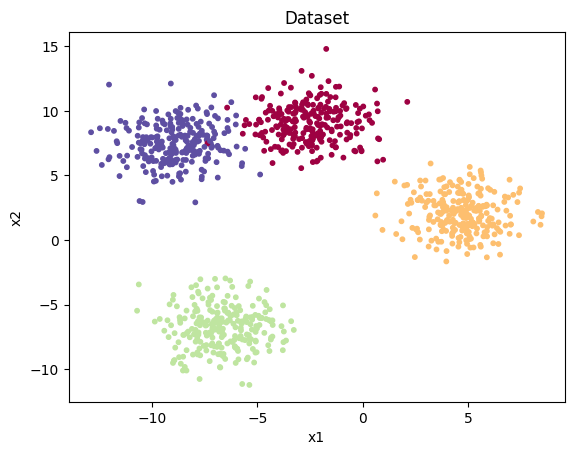

In [24]:
# Create multiclass data

x, y = ds.make_blobs(n_samples=1000, n_features=2,
                     centers=4, cluster_std=1.5, random_state=42)


# Turn data into tensors
x = th.from_numpy(x).float()
y = th.from_numpy(y).float()

# Split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Plot the dataset
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Spectral, s=10)
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Dataset")
plt.show()


#### Building a Multi-Class Classification Model in PyTorch

In [25]:
# Set the device to GPU if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [64]:
# Create Multi-class model
class MultiClassModel(th.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MultiClassModel, self).__init__()
        layers = [th.nn.Linear(input_size, hidden_size),
                  th.nn.ELU(),
                  th.nn.Linear(hidden_size, hidden_size),
                  th.nn.ReLU(),
                  th.nn.Linear(hidden_size, num_classes)]
        
        self.layers = th.nn.Sequential(*layers)

    def forward(self, x):
        out = self.layers(x)
        return out


#### Creating the Training and Testing loop for the Multi-Class PyTorch Model

In [65]:
# Create an instance of the model
model_e = MultiClassModel(2, 10, 4).to(device)

# Create a loss function
loss_fn = th.nn.CrossEntropyLoss()

# Create an optimizer
optimizer = th.optim.SGD(model_e.parameters(), lr=0.01, momentum=0.9)

In [66]:
# Create Teaining loop
def train_model(model, x_train, y_train, x_test, y_test, loss_fn, optimizer, epochs):
    """
    Train the model.

    Args:
        model (_type_): _description_
        x_train (_type_): _description_
        y_train (_type_): _description_
        x_test (_type_): _description_
        y_test (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
        epochs (_type_): _description_

    Returns:
        _type_: _description_
    """
    train_losses = []
    train_matrics = []
    test_losses = []
    test_matrics = []

    # Create multi-class accuracy metric
    accuracy = thm.Accuracy(task="multiclass", num_classes=4, top_k=1)
    
    for epoch in range(epochs):
        
        # Train
        model.train()

        # Make predictions
        y_train_pred = model(x_train).softmax(dim=1)

        # Calculate loss
        train_loss = loss_fn(y_train_pred, y_train.long())

        # Calculate accuracy
        train_acc = accuracy(y_train_pred, y_train)

        # Reset gradients
        optimizer.zero_grad()

        # Calculate gradients
        train_loss.backward()

        # Update parameters
        optimizer.step()

        # Test
        model.eval()

        with th.inference_mode():
            # Make predictions
            y_test_pred = model(x_test)

            # Calculate loss
            test_loss = loss_fn(y_test_pred, y_test.long())

            # Calculate accuracy
            test_acc = accuracy(y_test_pred, y_test)

        train_losses.append(train_loss.item())
        train_matrics.append(train_acc)
        test_losses.append(test_loss.item())
        test_matrics.append(test_acc)

        if epoch % 100 == 0:
            # Print the progress
            print(f"Epoch {epoch}: train loss: {train_losses[epoch]}, train acc: {train_matrics[epoch]}")
            
            print(f"Epoch {epoch}: test loss: {test_losses[epoch]}, test acc: {test_matrics[epoch]}")

    return train_losses, train_matrics, test_losses, test_matrics

In [67]:
train_losses, train_matrics, test_losses, test_matrics = train_model(model_e, x_train, y_train, x_test, y_test, loss_fn, optimizer, 1000)

Epoch 0: train loss: 1.329802393913269, train acc: 0.26374998688697815
Epoch 0: test loss: 1.2077927589416504, test acc: 0.28999999165534973
Epoch 100: train loss: 0.7705861926078796, train acc: 0.9925000071525574
Epoch 100: test loss: 0.037129152566194534, test acc: 0.9900000095367432
Epoch 200: train loss: 0.7588248252868652, train acc: 0.9937499761581421
Epoch 200: test loss: 0.019247883930802345, test acc: 0.9900000095367432
Epoch 300: train loss: 0.7559383511543274, train acc: 0.9937499761581421
Epoch 300: test loss: 0.014288225211203098, test acc: 0.9950000047683716
Epoch 400: train loss: 0.7545793056488037, train acc: 0.9937499761581421
Epoch 400: test loss: 0.011904276907444, test acc: 0.9950000047683716
Epoch 500: train loss: 0.7537714242935181, train acc: 0.9937499761581421
Epoch 500: test loss: 0.01052013598382473, test acc: 0.9950000047683716
Epoch 600: train loss: 0.7532250881195068, train acc: 0.9937499761581421
Epoch 600: test loss: 0.009628063067793846, test acc: 0.9950

In [70]:
# Check the predictions
y_test_pred = model_e(x_test).softmax(dim=1)
print(y_test_pred)
print(y_test_pred.argmax(dim=1))
print(y_test)

accuracy = thm.Accuracy(task="multiclass", num_classes=4, top_k=1)
print(accuracy(y_test_pred, y_test))

tensor([[5.0780e-06, 9.9998e-01, 5.2167e-06, 1.2179e-05],
        [7.4353e-06, 6.9995e-07, 1.0349e-04, 9.9989e-01],
        [1.4934e-09, 8.6960e-10, 1.0000e+00, 3.1845e-06],
        [1.2022e-05, 9.9988e-01, 2.9090e-05, 7.4803e-05],
        [9.9971e-01, 2.3172e-04, 1.0541e-05, 4.4451e-05],
        [4.7081e-07, 3.0364e-08, 2.2870e-05, 9.9998e-01],
        [8.4780e-09, 3.9543e-09, 1.0000e+00, 1.2101e-06],
        [9.9986e-01, 7.7118e-05, 6.3079e-06, 5.7692e-05],
        [2.9229e-11, 2.3304e-11, 9.9999e-01, 4.9816e-06],
        [9.9984e-01, 1.0652e-04, 7.5367e-06, 4.7735e-05],
        [9.9966e-01, 1.0056e-04, 1.3285e-05, 2.3028e-04],
        [3.3794e-07, 1.0000e+00, 9.3467e-07, 3.1763e-06],
        [9.9986e-01, 9.8537e-05, 5.8563e-06, 3.6156e-05],
        [9.9993e-01, 3.4420e-05, 2.3033e-06, 2.8631e-05],
        [9.9995e-01, 2.5477e-05, 1.5109e-06, 2.0859e-05],
        [9.1855e-04, 1.8981e-05, 2.9005e-04, 9.9877e-01],
        [4.3455e-06, 4.0079e-07, 9.1466e-05, 9.9990e-01],
        [1.956